In [97]:
""" Define a redness index on copepod microscope images : first try

Usage:
======
    1. Read, segment and avoid artefacts
    - Read all raw copepod color images from a folder [x]
    - Zoom and/or avoid dark parts from the microscope or part of the petri box [ ] > not tried yet
    - Separate the copepod from the background [x] > but some parts often remains unsegmented
    - Save modified images [ ] and array of background definition [x]
    
    2. Intercalibrate RGB channels
     - Read segmented and clean images and associate background file [x]
     - Intercalibrate them from the backround RGB values [x]
     - Save calibrated images [X]
     
    3. Quantify redness
    - Identify red pixels = 2 differed methods tested (LHC colorspace and color deconvolution) [x]
    - Quantify % of red pigments on the segmented copepod > [ ] > no, this will be done after other technics of copepod segmentation
    - Quantify total redness (normalisation by pixel size and/or prosome lenght)[ ] > future step
    
> After this test, we agreed that color deconvolution is the best method to use. With this method, it is not useful to 
segment the copepod from the background as a first step. So in following scripts, our objectives are:
Script 2:
1- Calibrate images without segmentation (using the median not the mean in mR = mG = mB = constant)
2- Identity red pixels with the color deconvolution method
3- Quantify red color intensity with the normalised OD levels between images

Script 3:
Test different types of datasets (various complexity of images)

Script 4: 
4- Quantify red color intensity taking into account the pixel size (absolute redness index)
5- Compute a quantitiative redness index between 0 and 1. 

Scrip 5: 
6- Segment the main part of the body without antennas
7- Segment the copepod by the boolean union between body segmentation and redness of antennas
8- Counting proportions of redpixels among this segmentation (relative redness index)
     
"""

__authors__ = ("Laure Vilgrain", "Jean-Olivier Irisson", "Simon-Martin Schröder")
__contact__ = ("laure.vilgrain@imev-mer.fr", "irisson@normalesup.org", "sms@informatik.uni-kiel.de")
__version__ = "1.0.0"
__date__ = "04-2021"

In [98]:
import pandas as pd
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt
from skimage import io, data, color, exposure, feature, morphology, measure
from scipy import ndimage as ndi
import copy

from skimage.io import imread
from skimage.color import separate_stains
from scipy import linalg
from skimage.filters import threshold_otsu

In [ ]:
### 1. Read, segment and avoid artefacts

Original images


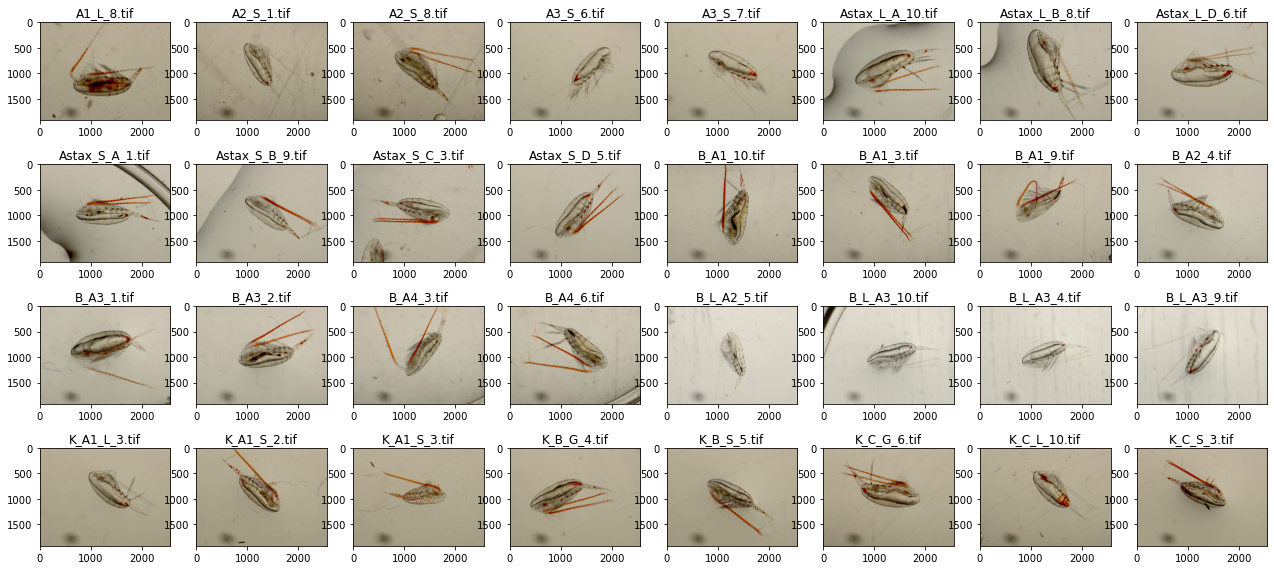

Mean original RGB value among images is 166.20805089950562 and standard deviation is 19.54411069209802


In [100]:
## 1.1. Read and display original images, remove black parts and other artefacts

imgs_list = os.listdir("imgs_test/dataset1/") # all images to read
imgs_list.sort() # sort images to visualize them in the same order
original_RGB = []

print("Original images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
    filename = "imgs_test/dataset1/" + imgs_list[i-1]
    img = io.imread(filename)
    original_RGB.append(np.mean(img, axis=(0,1)))# stock the RGB original values in a list
    fig.add_subplot(rows, columns, i)
    plt.title(imgs_list[i-1])
    plt.imshow(img)
plt.show()
print("Mean original RGB value among images is", np.mean(original_RGB), "and standard deviation is", np.std(original_RGB))

In [109]:
## 1.2. Separate copepod from the background
imgs_list = os.listdir("imgs_test/dataset1/")
imgs_list.sort() # sort images to visualize them in the same order

imgs_back = [] # prepare a list to save backgrounds of images
avr_back_list = [] # prepare a list to save average RGB values of the back
    
for image in imgs_list:
    filename = "imgs_test/dataset1/" + image
    img = io.imread(filename)
    
    # 1. Segment regions of the image
    img_grey = color.rgb2gray(img) # transform in black and white
    img_eq = exposure.rescale_intensity(img_grey) # enhance contrast
    img_edges = feature.canny(img_eq, sigma=2) # find edges
    img_dilat = morphology.binary_dilation(img_edges, morphology.disk(20)) #grow edges
    img_close = morphology.binary_closing(img_dilat, morphology.disk(30)) # fill small regions
    img_fill = ndi.morphology.binary_fill_holes(img_close) # fill larger holes
    #io.imshow(im_fill)
    #plt.show()
    img_label = measure.label(img_fill) #label each region of the image
    #io.imshow(img_label)
    #plt.show()
    
    # 2. Get largest object and define the background
    props = measure.regionprops(img_label) # measure properties of all objects
    #props0 contains the foreground object with label=1
    areas = [p.area for p in props] # get they areas 
    i_max = np.argmax(areas) 
    #print("Here are the areas of the different regions labelled on the image : ", areas)
    back = (img_label != props[i_max].label)
    imgs_back.append(back)
    # NB: label = 0 is the background in the labelled image,
    #     so object 0 is label = 1, object 1 is label = 2 etc.
    img_blanked = copy.copy(img)
    img_blanked[~back,:] = 0 # what does it mean ? replace all values that correspond to the largest object by 0 (for which back is FALSE)
    # print(img_blanked[:3])
    io.imsave("imgs_processed/test1/dataset1_segmented/" + image + "_segmented.jpg", img_blanked)
    
    # 3. Compute average intensity of the background only (so the copepod does not influence the following calibration)
    avg = np.mean(img[back,:])
    avr_back_list.append(avg)

print("Original average intensities in RGB are saved in a list for next images calibration:", avr_back_list)
print("An array containing background definition by image is saved")

Original average intensities in RGB are saved in a list for next images calibration: [157.58707649990887, 154.38306771880963, 150.12604688943213, 168.5587349680397, 168.49827490556984, 162.34247488291027, 165.80071855570162, 171.94899035483795, 160.69430751354963, 171.3877992329292, 169.68040405159852, 173.61877979757014, 171.28938842960792, 169.91209391084647, 170.88198232275903, 182.3460047253725, 176.77533545592306, 178.116160959771, 175.14451711977105, 174.5935938532193, 207.03308524066904, 201.46717150556753, 205.2316793492793, 204.1448086812375, 159.7168321315233, 158.70296616562086, 160.06907809114145, 162.14721100759672, 160.60568534115097, 160.0000608624468, 158.2603443700664, 160.52570519079575]
An array containing background definition by image is saved


Segmented images


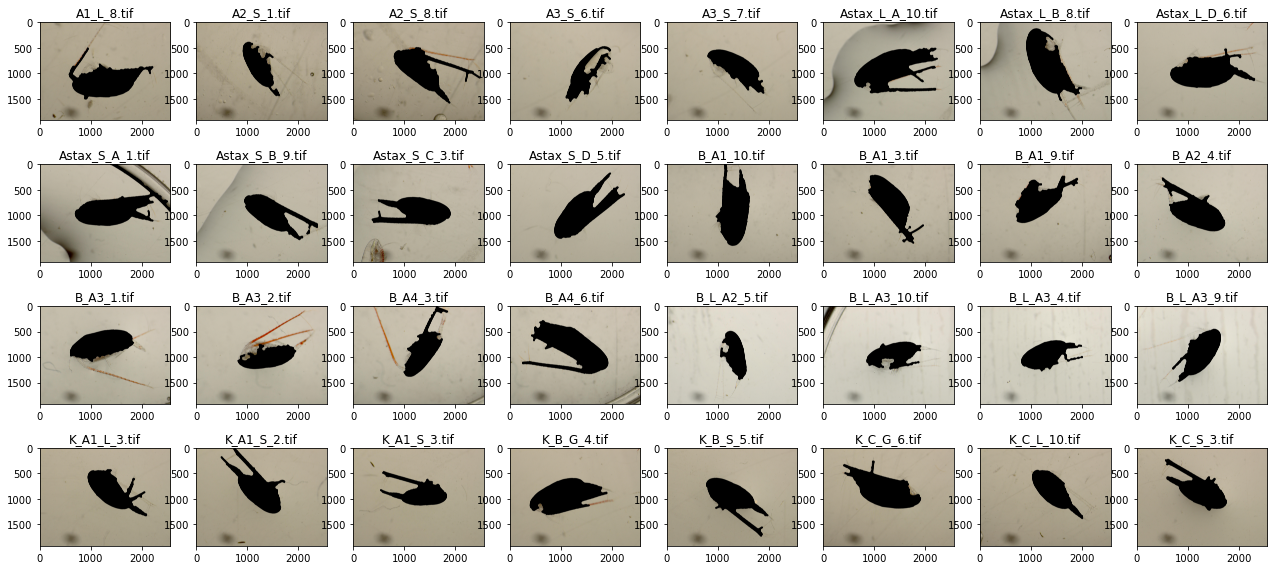

In [110]:
imgs_proc_list = os.listdir("imgs_processed/test1/dataset1_segmented/")
imgs_proc_list.sort() # sort images to visualize them in the same order

print("Segmented images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
    filename = "imgs_processed/test1/dataset1_segmented/" + imgs_proc_list[i-1]
    img = io.imread(filename)
    fig.add_subplot(rows, columns, i)
    plt.title(imgs_list[i-1])
    plt.imshow(img)
plt.show()

In [10]:
## 1.3. Save array of background definition and RGB averages 

In [11]:
### 2. Intercalibrate RGB channels

In [86]:
## 2.1. Calibrate image color based on mean average RGB intensity of all images considered

imgs_list = os.listdir("imgs_test/dataset1/")
imgs_list.sort() # sort images to visualize them in the same order
nb_imgs=32
imgs_calib = [] #list with calibrated images
 
for i in range(1, nb_imgs +1):
    filename = "imgs_test/dataset1/" + imgs_list[i-1] # imgs_list is still the same
    img = io.imread(filename)
    # compute average intensity per channel for the background only
    avg_r = np.mean(img[imgs_back[i-1],0])
    avg_g = np.mean(img[imgs_back[i-1],1])
    avg_b = np.mean(img[imgs_back[i-1],2])
    
    # convert all channels to have similar average intensities on the orginal image
    img_calib = copy.copy(img)
    img_calib[:,:,0] = np.minimum(img[:,:,0] / avg_r * np.mean(avr_back_list), 255)
    img_calib[:,:,1] = np.minimum(img[:,:,1] / avg_g * np.mean(avr_back_list), 255)
    img_calib[:,:,2] = np.minimum(img[:,:,2] / avg_b * np.mean(avr_back_list), 255)
    # NB: check that this stays in [0,255] = [black, white]
    imgs_calib.append([img_calib])
    io.imsave("imgs_processed/test1/dataset1_calibrated/" + imgs_list[i-1] + "_calibrated.jpg", img_calib)
    
print("Calibrated images are stored in a list")

# TODO : plot the distribution of RGB values to see if there are outliers

Calibrated images are stored in a list


In [65]:
# 2.2 Visualize images and compute new RGB average and standard deviation

Calibrated images


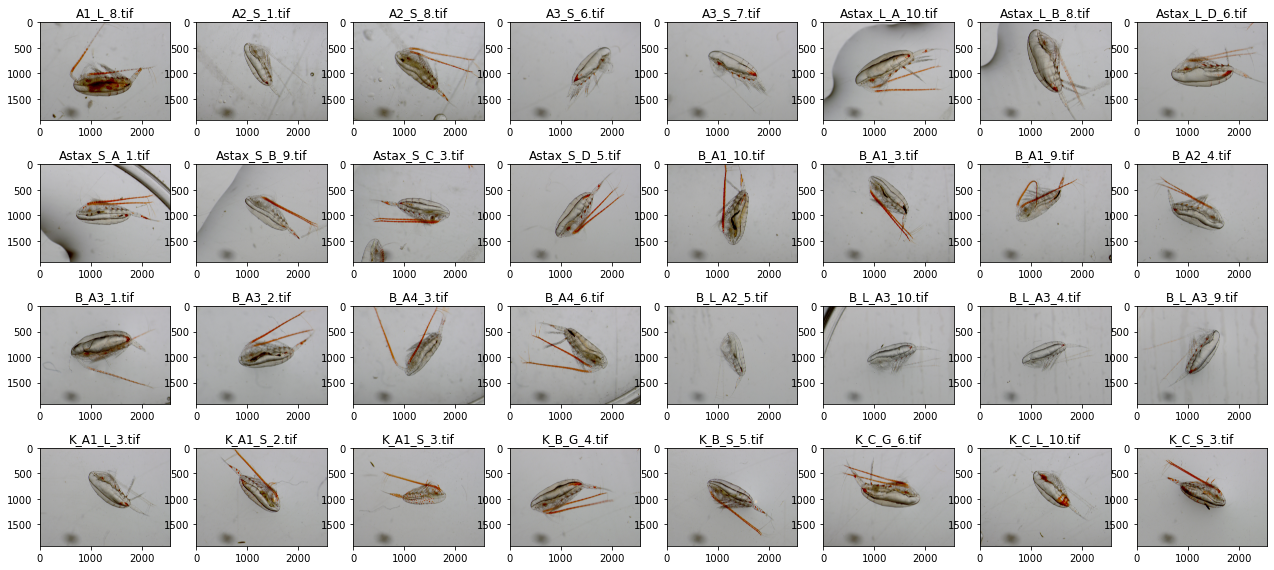

Average RGB value among images is 165.57862609439425 and standard deviation is 2.1198498024912436


In [87]:
imgs_calib_list = os.listdir("imgs_processed/test1/dataset1_calibrated/")
imgs_calib_list.sort() # sort images to visualize them in the same order
final_RGB = [] #list with final RGB values

print("Calibrated images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
    filename = "imgs_processed/test1/dataset1_calibrated/" + imgs_calib_list[i-1]
    img = io.imread(filename)
    final_RGB.append(np.mean(img, axis=(0,1)))# stock the RGB calibrated values in a list
    fig.add_subplot(rows, columns, i)
    plt.title(imgs_list[i-1])
    plt.imshow(img)
plt.show()
print("Average RGB value among images is", np.mean(final_RGB), "and standard deviation is", np.std(final_RGB))

In [88]:
for i in range(1, 10):
    filename_original = "imgs_test/dataset1/" + imgs_list[i-1] # imgs_list is still the same
    filename_calibrated = "imgs_processed/test1/dataset1_calibrated/" + imgs_calib_list[i-1]
    img_original = io.imread(filename_original)
    img_calibrated = io.imread(filename_calibrated)
    print("The orginal color intensities in R,G,B for the entire image are :", np.mean(img_original, axis=(0,1)))
    print("The new color intensities in R,G,B for the entire image are :", np.mean(img_calibrated, axis=(0,1)))
    print("---")


The orginal color intensities in R,G,B for the entire image are : [164.49201192 152.59141724 128.35565348]
The new color intensities in R,G,B for the entire image are : [163.53317749 160.39251892 157.62461182]
---
The orginal color intensities in R,G,B for the entire image are : [166.90586568 156.84050293 133.27809428]
The new color intensities in R,G,B for the entire image are : [168.83329041 168.3164091  167.54056295]
---
The orginal color intensities in R,G,B for the entire image are : [160.39187195 149.03274434 124.84347188]
The new color intensities in R,G,B for the entire image are : [166.06680298 164.53105509 162.16229309]
---
The orginal color intensities in R,G,B for the entire image are : [179.77011963 170.80871297 148.05744893]
The new color intensities in R,G,B for the entire image are : [168.52559611 167.93723958 167.52501465]
---
The orginal color intensities in R,G,B for the entire image are : [179.31457011 170.16883647 147.27671529]
The new color intensities in R,G,B fo

In [14]:
### 3. Redness quantification

Red pixels identification - method 1 - LHC color space


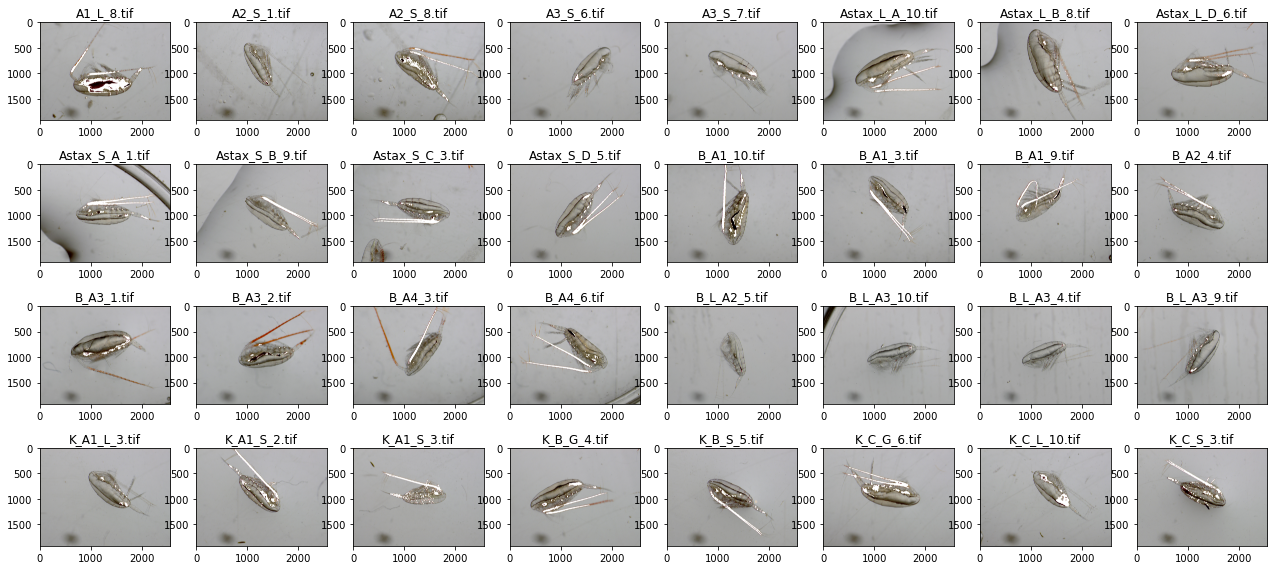

In [89]:
## 3.1. Identify red pigments (method 1 - LHC color space) 

print("Red pixels identification - method 1 - LHC color space")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(1, len(imgs_calib_list) +1):
    filename_calibrated = "imgs_processed/test1/dataset1_calibrated/" + imgs_calib_list[i-1]
    img_calib = io.imread(filename_calibrated)
    img_lch = color.lab2lch(color.rgb2lab(img_calib))
    
    # Segment the red portions
    # get the reds based on hue (in [0,360]), color intensity, lightness
    # and the copepod mask
    # reference for hue in degrees https://en.wikipedia.org/wiki/Hue
    hues = img_lch[:,:,2] / 2 * np.pi * 360 #hues in degrees
    reds = ((hues < 60) | (hues > 300)) & \
           (img_lch[:,:,1] > 27) & \
           ((img_lch[:,:,0] > 10) & (img_lch[:,:,0] < 89)) & \
           ~imgs_back[i-1]
    
    # Show on original image
    img_highlight = copy.copy(img_calib)
    img_highlight[:,:,0][reds] = 255
    img_highlight[:,:,1][reds] = 255
    img_highlight[:,:,2][reds] = 255
    io.imsave("imgs_processed/test1/dataset1_method1/" + imgs_calib_list[i-1] + "_LHCmethod.jpg", img_highlight)
    
    # Plot
    fig.add_subplot(rows, columns, i)
    plt.title(imgs_list[i-1])
    plt.imshow(img_highlight)
plt.show()

'normalized OD matrix :'

array([[ 0.51  ,  0.11  ,  0.06  ],
       [ 0.65  ,  0.65  ,  0.65  ],
       [ 0.0325, -0.2925,  0.26  ]])

'inversed OD matrix = color deconvolution matrix:'

array([[ 2.32876712, -0.29926238,  0.21074816],
       [-0.95890411,  0.84720759, -1.8967334 ],
       [-1.36986301,  0.99051633,  1.68598525]])

Red pixels identification - method 2 - Color deconvolution


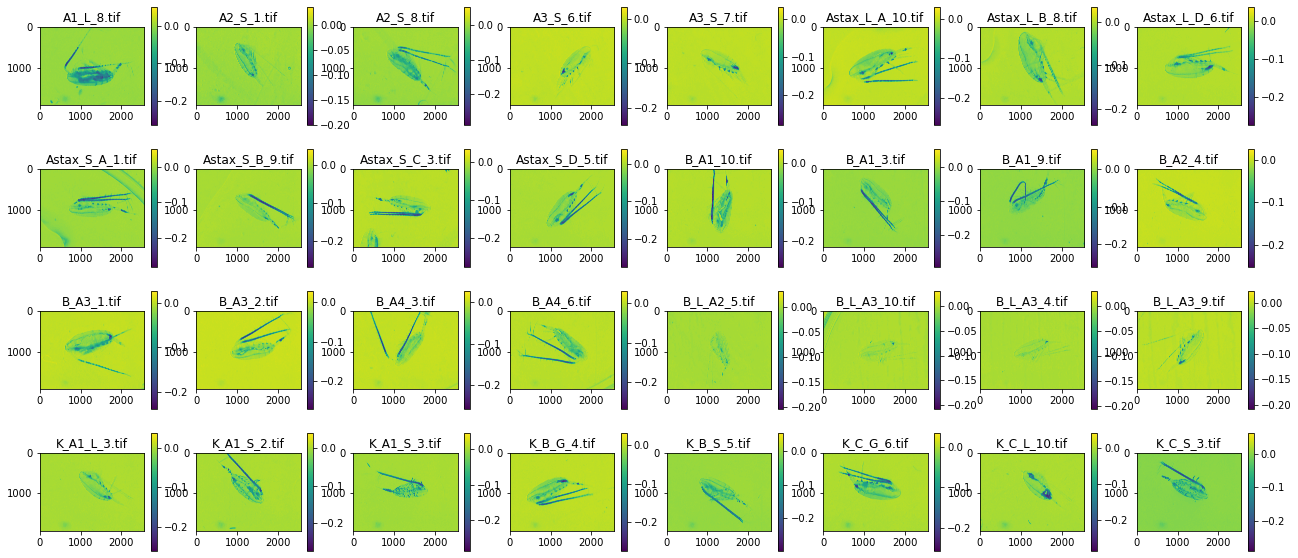

In [91]:
## 3.1. Identify red pigments (method 2 - color deconvolution) 

# Optical Density (OD) matrix : 
rgb_from_stains = np.array([
    [0.51, 0.11, 0.06],
    # Background
    [0.65, 0.65, 0.65],
    # Placeholder
    [0,0,0]])

# Calculate residuals = normalize the OD matrix: 
rgb_from_stains[2, :] = np.cross(rgb_from_stains[0, :], rgb_from_stains[1, :])
display("normalized OD matrix :", rgb_from_stains)

# Calculate matrix inverse with linalg.inv :
stains_from_rgb = linalg.inv(rgb_from_stains)
display("inversed OD matrix = color deconvolution matrix:", stains_from_rgb)


print("Red pixels identification - method 2 - Color deconvolution")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(1, len(imgs_calib_list) +1):
    filename_calibrated = "imgs_processed/test1/dataset1_calibrated/" + imgs_calib_list[i-1]
    img_calib = io.imread(filename_calibrated)
    stains = separate_stains(img_calib, stains_from_rgb) # Extract stains 
    red = stains[...,0]# RGB to stain color space conversion (sickit image)
    # threshold using intensities histogramm on the image 
    thr = threshold_otsu(red, nbins=50)
    #display(thr)
    red_mask = red < (thr-0.015)# red mask :
    
    # Show on original image
    img_highlight = copy.copy(img_calib)
    img_highlight[:,:,0][red_mask] = 255
    img_highlight[:,:,1][red_mask] = 255
    img_highlight[:,:,2][red_mask] = 255
    io.imsave("imgs_processed/test1/dataset1_method2/" + imgs_calib_list[i-1] + "_RGBdeconvmethod.jpg", img_highlight)
    
    # Plot
    fig.add_subplot(rows, columns, i)
    plt.title(imgs_list[i-1])
    low, high = np.quantile(red, (1, .0))
    plt.imshow(red, vmin=high, vmax = low)
    plt.colorbar()
plt.show()

Red pixels identification - method 2 - Color deconvolution


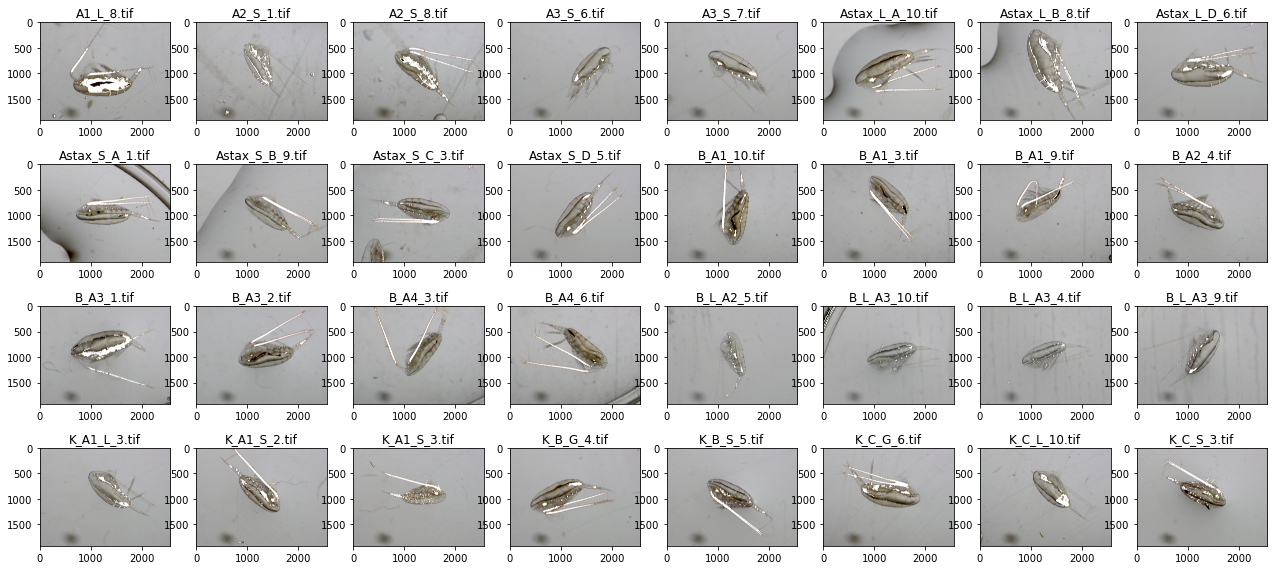

In [93]:
imgs_redpix2_list = os.listdir("imgs_processed/test1/dataset1_method2/")
imgs_redpix2_list.sort() # sort images to visualize them in the same order

print("Red pixels identification - method 2 - Color deconvolution")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
    filename = "imgs_processed/test1/dataset1_method2/" + imgs_redpix2_list[i-1]
    img = io.imread(filename)
    final_RGB.append(np.mean(img, axis=(0,1)))# stock the RGB calibrated values in a list
    fig.add_subplot(rows, columns, i)
    plt.title(imgs_list[i-1])
    plt.imshow(img)
plt.show()